<a href="https://colab.research.google.com/github/sanaz-mahmoudi/sanazmahmoudi/blob/main/Newcastle_University_Interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre Interview Task**

## Requirements

In [6]:
# PYOMO
!pip install -q pyomo
import pyomo.environ as pe

# NUMPY
import numpy as np

# GLPK
!apt-get install -y -qq glpk-utils
glpk = pe.SolverFactory('glpk', executable='/usr/bin/glpsol')

# PyPlot
import matplotlib.pyplot as plt

# OTHER
import pandas as pd

## Input Data

       Thermal Power Plant Data      
    bus  pmin  pmax  o_cost
g0    0     0   250      50
              Line Data              
    from  to  pmax
l0     0   1   100
l1     1   2   100
l2     0   2   100
      Sulphur-Flow Battery Data      
    bus  pmin  pmax  b_c
b0    1     0   100   24
            Renewable Data           
    bus  pmin  pmax  o_cost
w0    1     0   150       0
           Load Demand Data          
    bus  pmax
d0    2   100
 Hourly Demand and Renewable Profile 
Hourly Load Demand =
     day hour bus        dem
0    01   00   2  19.199484
1    01   01   2  15.553450
2    01   02   2  10.650177
3    01   03   2   7.848147
4    01   04   2   7.711271
..   ..  ...  ..        ...
667  28   19   2  69.836309
668  28   20   2  62.527832
669  28   21   2  49.590679
670  28   22   2  34.204314
671  28   23   2  26.294096

[672 rows x 4 columns]
Hourly Renewable Generation =
     day hour bus        gen
0    01   00   1  24.037267
1    01   01   1  27.078261
2    01  

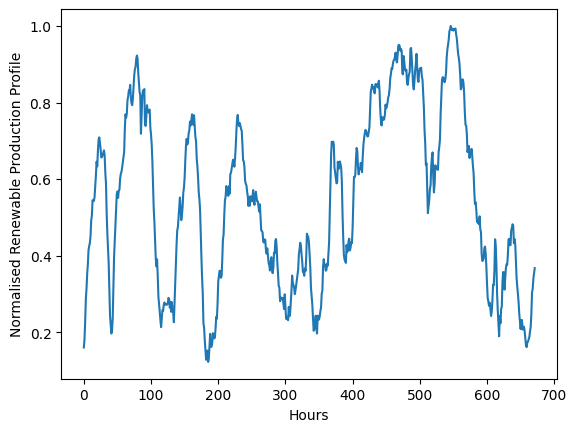

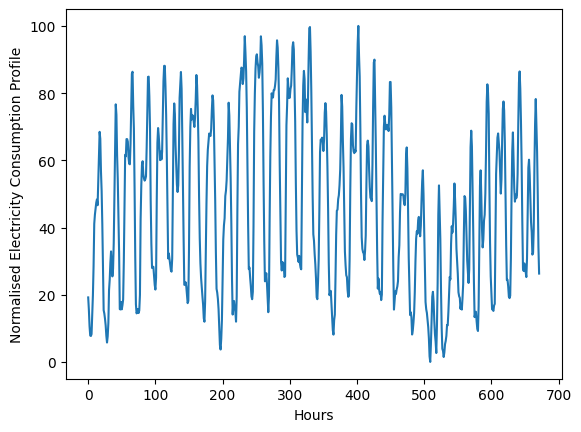

In [11]:
print('=====================================')
print('       Thermal Power Plant Data      ')
print('=====================================')
data_gen = [[0,0,250,50]]
ng = len(data_gen)
gen = pd.DataFrame(data_gen,index=['g'+str(i) for i in range(ng)],columns=['bus','pmin','pmax','o_cost'])
print(gen)

print('=====================================')
print('              Line Data              ')
print('=====================================')
data_lin = [[0,1,100],[1,2,100],[0,2,100]]
nl = len(data_lin)
lin = pd.DataFrame(data_lin,index=['l'+str(i) for i in range(nl)],columns=['from','to','pmax'])
print(lin)

print('=====================================')
print('      Sulphur-Flow Battery Data      ')
print('=====================================')
data_bat = [[1,0,100,24]]
nb = len(data_bat)
b = pd.DataFrame(data_bat,index=['b'+str(i) for i in range(nb)],columns=['bus','pmin','pmax','b_c'])
print(b)

print('=====================================')
print('            Renewable Data           ')
print('=====================================')
data_ren = [[1,0,150,0]]
nw = len(data_ren)
ren = pd.DataFrame(data_ren,index=['w'+str(i) for i in range(nw)],columns=['bus','pmin','pmax','o_cost'])
print(ren)

print('=====================================')
print('           Load Demand Data          ')
print('=====================================')
data_dem = [[2,100]]
nd = len(data_dem)
dem = pd.DataFrame(data_dem,index=['d'+str(i) for i in range(nd)],columns=['bus','pmax'])
print(dem)

print('=====================================')
print(' Hourly Demand and Renewable Profile ')
print('=====================================')
h_data = pd.read_csv('https://raw.githubusercontent.com/sanaz-mahmoudi/sanazmahmoudi/refs/heads/main/Hourly%20Profiles.csv')

# Extract Days, Hours, Renewable Production, Consumption
h_data['day']  = h_data['Time'].str.split('T').str[0].str[-2:]
h_data['hour'] = h_data['Time'].str.split('T').str[1].str[:2]
h_data['prod'] = h_data['Normalised Renewable Production Profile']
h_data['cons'] = h_data['Normalised Electricity Consumption Profile']

# Create DataFrame for Hourly Load Demand
h_dem_b = pd.DataFrame(np.outer(h_data['cons'].values, dem['pmax'].values), columns=dem['bus'])   # Determine the Hourly Demand Profile of each Bus
h_dem_b['day']  = h_data['day'].values                                                            # Add Day from h_data
h_dem_b['hour'] = h_data['hour'].values                                                           # Add Hour from h_data
h_dem = h_dem_b.melt(id_vars=['day', 'hour'], var_name='bus', value_name='dem')                   # Melt into the Desired Format
print('Hourly Load Demand =\n', h_dem)

# Create DataFrame for Hourly Renewable Generation
h_ren_b = pd.DataFrame(np.outer(h_data['prod'].values, ren['pmax'].values), columns=ren['bus'])   # Determine the Hourly Renewable Generation Profile of each Bus
h_ren_b['day']  = h_data['day'].values                                                            # Add Day from h_data
h_ren_b['hour'] = h_data['hour'].values                                                           # Add Hour from h_data
h_ren = h_ren_b.melt(id_vars=['day', 'hour'], var_name='bus', value_name='gen')                   # Melt into the Desired Format
print('Hourly Renewable Generation =\n',h_ren)

print('=====================================')
print('     PyPlots for Hourly Profiles     ')
print('=====================================')
h_data['Normalised Renewable Production Profile'] = h_data['Normalised Renewable Production Profile']
plt.plot(h_data['Normalised Renewable Production Profile']*ren['pmax'].values)
plt.xlabel('Hours (h)')
plt.ylabel('Renewable Production (MW)')
plt.show()

plt.plot(h_data['Normalised Electricity Consumption Profile']*dem['pmax'].values)
plt.xlabel('Hours (h)')
plt.ylabel('Electricity Consumption (MW)')
plt.show()


## Optimization Model

In [ ]:
# Model
m = pe.ConcreteModel()

# Sets
m.g = pe.Set(initialize=gen.index.tolist())
m.w = pe.Set(initialize=list(range(nw)))
m.d = pe.Set(initialize=list(range(nd)))
m.td = pe.Set(initialize=list(h_data['day'].unique()))
m.th = pe.Set(initialize=list(h_data['hour'].unique()))
m.n = pe.Set(initialize=list(range(nb)))
m.l = pe.Set(initialize=list(range(nl)))

# Variables
m.pg = pe.Var(m.g,m.td,m.th,within=pe.NonNegativeReals)         # Generation
m.pw = pe.Var(m.w,m.td,m.th,within=pe.NonNegativeReals)
m.pds = pe.Var(m.d,m.td,m.th,within=pe.Binary)                  # Demand Shedding
m.prs = pe.Var(m.w,m.td,m.th,within=pe.NonNegativeReals)        # Renewable Shedding
m.pl = pe.Var(m.l,m.td,m.th,within=pe.Reals)                    # Active Power

# Objective function
def obj_rule(m):
  return sum(gen.loc[g,'o_cost']*m.pg[g,td,th] for g in m.g for td in m.td for th in m.th)
m.obj = pe.Objective(rule=obj_rule)

# Constraints
# Energy balance
def bal_rule(m,n,td,th):
  return sum(m.pg[g,td,th] for g in m.g if gen['bus'][g] == n) + \
         sum(m.pw[w,td,th] for w in m.w if ren['bus'][w] == n) + \
         sum(m.pl[l,td,th] for l in m.l if lin['to'][l] == n) == \
         sum(m.pl[l,td,th] for l in m.l if lin['from'][l] == n) + \
         sum(h_dem.loc[d,'cons'] for d in m.d if h_dem['bus'][d] == n)
m.bal = pe.Constraint(m.n, m.td, m.th, rule=bal_rule)

# Minimum Thermal Generation Capacity
def min_gen_rule(m,g,td,th):
    return m.pg[g,td,th] >= gen['pmin'][g]
m.min_gen = pe.Constraint(m.g, m.td, m.th, rule=min_gen_rule)

# Minimum Renewable Generation Capacity
def min_ren_rule(m,w,td,th):
    return m.pw[w,td,th] >= ren['pmin'][w]
m.min_ren = pe.Constraint(m.w, m.td, m.th, rule=min_ren_rule)

# Minimum Line Flow
def min_flow_rule(m,l,td,th):
    return m.pl[l,td,th] >= -lin['pmax'][l]
m.min_flow = pe.Constraint(m.l, m.td, m.th, rule=min_flow_rule)

# Maximum Thermal Generation Capacity
def max_gen_rule(m,g,td,th):
    return m.pg[g,td,th] <= gen['pmax'][g]
m.max_gen = pe.Constraint(m.g, m.td,  m.th, rule=max_gen_rule)

# Maximum Renewable Generation Capacity
def max_ren_rule(m,w,td,th):
    return m.pw[w,td,th] <= ren['pmax'][w]
m.max_ren = pe.Constraint(m.w, m.td, m.th, rule=max_ren_rule)

# Maximum Line Flow
def max_flow_rule(m,l,td,th):
    return m.pl[l,td,th] <= lin['pmax'][l]
m.max_flow = pe.Constraint(m.l, m.td, m.th, rule=max_flow_rule)

# Solve problem using GLPK solver
glpk.solve(m).write()

# Print results
#print('x1 =',m.x1.value)
#print('x2 =',m.x2.value)
print('Optimal Value =',m.obj())

/tmp/ipython-input-2440603243.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pw[w,td,th] for w in m.w if ren['bus'][w] == n) + \
/tmp/ipython-input-2440603243.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pl[l,td,th] for l in m.l if lin['to'][l] == n) == \
/tmp/ipython-input-2440603243.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pl[l,td,th] for l in m.l if lin['from'][l] == n) + \
/tmp/ipython

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 7392
  Number of variables: 3360
  Number of nonzeros: 8736
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.04866480827331543
# ----------------------------------------------------------
#   Solution Information
# --------------------------------